In [17]:
import os
import random
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import akross_common_functions as AK

#local import 

# Import saline snow permittivity model
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
from smrt import make_ice_column, make_snowpack
from smrt.core.globalconstants import PSU
from smrt import make_model
from smrt.inputs import altimeter_list
from smrt.emmodel.iba import derived_IBA

#turn off pandas warning from smrt
pd.set_option('mode.chained_assignment',None)

This notebook contains the following 4 sections

1. Prepare simulation
2. Signal contribution (surface, interface and volume)
3. Sensitivity analysis for Ku
4. Sensitivity analysis for Ka

### 1. Prepare simulation

- import profile derived from smp ready to create SMRT simulation.
- CB and Eureka22 an join together to represent FYI. A random subset from eureka (500 snowpacks) is taken of same size from CB. This is just to allow faster simulation.

In [18]:
#CB
#get smp profile for CB
with open('smrt_in-out/smp_profile_CB_3cm', 'rb') as pickle_file:
    smp_CB = pickle.load(pickle_file)

#restructure to list of profile
# Flatten dict of dicts
list_smp_CB = [profile for site, item in smp_CB.items() for name, profile in item.items()]

#Eureka
# Get list of sites (upper folders)
# Data from https://doi.org/10.5281/zenodo.4068349
#data_dir = '../DATA/SMP/Sites'
data_dir = 'C:/Users/melochej/Documents/code-workshop/AKROSS/DATA/SMP/Sites'
list_of_sites = os.listdir(path=data_dir)
# Split Eureka and Alert sites
eureka_sites = [s for s in list_of_sites if 'Eureka' in s]

#get smp profile for Eureka
E_smp_files = []
for s in eureka_sites:
    E_smp_files.append(AK.find_site_smp_files(s, data_dir = data_dir))

# Flatten list of lists
all_eureka = list(itertools.chain(*E_smp_files))
# Remove all non .pnt files (NB some are .PNT)
eureka_smp_files = [s for s in all_eureka if 'pnt' in s.lower()]
#get only FYI
eureka_smp_fyi_files = [site for site in eureka_smp_files if 'FYI' in site]

#select randomly same number of snowpack of CB, so the mean waveform is not heavely weighted on eureka sites
#Eureka sites is 400 compared with 100 for CB
eureka_sub_files = random.sample(eureka_smp_fyi_files, len(list_smp_CB))

In [19]:
alert_salt = 1
eureka_salt = 3

In [20]:
#This function is used alot in the sensitivity section

def build_snowpack_FYI(list_smp_CB, eureka_files, ice_salinity = 5, ice_temp = 260, sea_ice_density = 910, eureka_salt = 3):
    """
    Build SMRT snowpack of CB and Eureka an join them
    """
    # Build SMRT snowpack
    CB_sp = AK.build_snowpack_pickle(list_smp_CB, ice_salinity, ice_temp, sea_ice_density)
    E_sp = AK.smp_snowpacks(eureka_files, layer_thickness=0.03, rough=False, permittivity = None, snow_salt = eureka_salt)
    return CB_sp + E_sp

FYI_sp = build_snowpack_FYI(list_smp_CB, eureka_sub_files)

make snowpack failed for C:/Users/melochej/Documents/code-workshop/AKROSS/DATA/SMP/Sites/Eureka_4_FYI/S34M0496.pnt


In [21]:
#Get MYI snowpack from Alert
# Get list of sites (upper folders)
# Data from https://doi.org/10.5281/zenodo.4068349
#data_dir = '../DATA/SMP/Sites'
data_dir = 'C:/Users/melochej/Documents/code-workshop/AKROSS/DATA/SMP/Sites'
list_of_sites = os.listdir(path=data_dir)
alert_sites = [s for s in list_of_sites if 'Alert' in s]

A_smp_files = []
for s in alert_sites:
    A_smp_files.append(AK.find_site_smp_files(s, data_dir = data_dir))
# Flatten list of lists
all_alert = list(itertools.chain(*A_smp_files))
# Remove all non .pnt files (NB some are .PNT)
alert_smp_files = [s for s in all_alert if 'pnt' in s.lower()]
MYI_sp = AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None,
                        sea_ice_density=880, snow_salt = alert_salt)


In [22]:
#set mean roughness value for snow and ice from AKROSS campaign

# value of ice optimized per (FYI=  mean of CB-Eureka 22 and Eureka 16, MYI = Alert)
mean_ice_rms_fyi = 0.0018
mean_ice_rms_myi = 0.0033
mean_ice_lc_fyi = 0.3
mean_ice_lc_myi = 0.07
# value measured for snow
mean_snow_rms = 0.004
mean_snow_lc = 0.16

In [23]:
#norm factor from notebook 3.1
normf = 1.4e-9

altimodel = make_model(derived_IBA(ssp), "nadir_lrm_altimetry", rtsolver_options=dict(return_contributions=True, theta_inc_sampling=8))
cryosat = altimeter_list.cryosat2_sin()
altika = altimeter_list.saral_altika()

In [24]:
alert_salt = 0
eureka_salt = 5

### 2. Signal contribution

- investigate signal contribution as a function of ice roughness
- check signal contribution at optimized roughness
- plot the results

In [25]:
#Ku
#investigate contribution as function of roughness
rough_array = np.linspace(0.0005,0.0045, 10)
rough_contribution_A, rough_contribution_CB = [], []
for rough in rough_array:
    #add salt for Alert
    AK.change_roughness(MYI_sp, rough, mean_ice_lc_myi, mean_snow_rms, mean_snow_lc)
    AK.change_roughness(FYI_sp, rough, mean_ice_lc_fyi, mean_snow_rms, mean_snow_lc)

    #simulate Ku and Ka
    res_A_Ku = altimodel.run(cryosat, MYI_sp, parallel_computation=True).sigma()
    res_CB_Ku = altimodel.run(cryosat, FYI_sp, parallel_computation=True).sigma()

    mean_simu_A_Ku = np.mean(res_A_Ku, axis = 0)/normf
    mean_simu_CB_Ku = np.mean(res_CB_Ku, axis = 0)/normf

    interface_myi_ku = np.mean(mean_simu_A_Ku.sel(contribution = 'interfaces').values) / np.mean(mean_simu_A_Ku.sel(contribution = 'total').values) *100
    surface_myi_ku = np.mean(mean_simu_A_Ku.sel(contribution = 'surface').values) / np.mean(mean_simu_A_Ku.sel(contribution = 'total').values) *100
    volume_myi_ku = np.mean(mean_simu_A_Ku.sel(contribution = 'volume').values) / np.mean(mean_simu_A_Ku.sel(contribution = 'total').values) *100

    interface_fyi_ku = np.mean(mean_simu_CB_Ku.sel(contribution = 'interfaces').values) / np.mean(mean_simu_CB_Ku.sel(contribution = 'total').values) *100
    surface_fyi_ku = np.mean(mean_simu_CB_Ku.sel(contribution = 'surface').values) / np.mean(mean_simu_CB_Ku.sel(contribution = 'total').values) *100
    volume_fyi_ku = np.mean(mean_simu_CB_Ku.sel(contribution = 'volume').values) / np.mean(mean_simu_CB_Ku.sel(contribution = 'total').values) *100 

    rough_contribution_A.append({'interface': interface_myi_ku, 'surface' : surface_myi_ku, 'volume' : volume_myi_ku})
    rough_contribution_CB.append({'interface': interface_fyi_ku, 'surface' : surface_fyi_ku, 'volume' : volume_fyi_ku})
rough_df_A_ku = pd.DataFrame(rough_contribution_A)
rough_df_CB_ku = pd.DataFrame(rough_contribution_CB)

In [26]:
#investigate contribution as function of roughness
rough_array = np.linspace(0.0005,0.0045, 10)
rough_contribution_A, rough_contribution_CB = [], []
for rough in rough_array:
    #add salt for Alert
    AK.change_roughness_geo(MYI_sp, rough, mean_ice_lc_myi, mean_snow_rms, mean_snow_lc)
    AK.change_roughness_geo(FYI_sp, rough, mean_ice_lc_fyi, mean_snow_rms, mean_snow_lc)

    #simulate Ku and Ka
    res_A_Ka = altimodel.run(altika, MYI_sp, parallel_computation=True).sigma()
    res_CB_Ka = altimodel.run(altika, FYI_sp, parallel_computation=True).sigma()

    mean_simu_A_Ka = np.mean(res_A_Ka, axis = 0)/normf
    mean_simu_CB_Ka = np.mean(res_CB_Ka, axis = 0)/normf

    interface_myi_ka = np.mean(mean_simu_A_Ka.sel(contribution = 'interfaces').values) / np.mean(mean_simu_A_Ka.sel(contribution = 'total').values) *100
    surface_myi_ka = np.mean(mean_simu_A_Ka.sel(contribution = 'surface').values) / np.mean(mean_simu_A_Ka.sel(contribution = 'total').values) *100
    volume_myi_ka = np.mean(mean_simu_A_Ka.sel(contribution = 'volume').values) / np.mean(mean_simu_A_Ka.sel(contribution = 'total').values) *100

    interface_fyi_ka = np.mean(mean_simu_CB_Ka.sel(contribution = 'interfaces').values) / np.mean(mean_simu_CB_Ka.sel(contribution = 'total').values) *100
    surface_fyi_ka = np.mean(mean_simu_CB_Ka.sel(contribution = 'surface').values) / np.mean(mean_simu_CB_Ka.sel(contribution = 'total').values) *100
    volume_fyi_ka = np.mean(mean_simu_CB_Ka.sel(contribution = 'volume').values) / np.mean(mean_simu_CB_Ka.sel(contribution = 'total').values) *100 

    rough_contribution_A.append({'interface': interface_myi_ka, 'surface' : surface_myi_ka, 'volume' : volume_myi_ka})
    rough_contribution_CB.append({'interface': interface_fyi_ka, 'surface' : surface_fyi_ka, 'volume' : volume_fyi_ka})
rough_df_A_ka = pd.DataFrame(rough_contribution_A)
rough_df_CB_ka = pd.DataFrame(rough_contribution_CB)

get contribution at optimized roughness

In [27]:
#Ku
#add salt for Alert
AK.change_roughness(MYI_sp, mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, mean_snow_lc)
AK.change_roughness(FYI_sp, mean_ice_rms_fyi, mean_ice_lc_fyi, mean_snow_rms, mean_snow_lc)

#simulate Ku and Ka
res_A_Ku = altimodel.run(cryosat, MYI_sp, parallel_computation=True).sigma()
res_CB_Ku = altimodel.run(cryosat, FYI_sp, parallel_computation=True).sigma()

mean_simu_A_Ku = np.mean(res_A_Ku, axis = 0)/normf
mean_simu_CB_Ku = np.mean(res_CB_Ku, axis = 0)/normf

interface_myi_ku = np.mean(mean_simu_A_Ku.sel(contribution = 'interfaces').values) / np.mean(mean_simu_A_Ku.sel(contribution = 'total').values) *100
surface_myi_ku = np.mean(mean_simu_A_Ku.sel(contribution = 'surface').values) / np.mean(mean_simu_A_Ku.sel(contribution = 'total').values) *100
volume_myi_ku = np.mean(mean_simu_A_Ku.sel(contribution = 'volume').values) / np.mean(mean_simu_A_Ku.sel(contribution = 'total').values) *100

interface_fyi_ku = np.mean(mean_simu_CB_Ku.sel(contribution = 'interfaces').values) / np.mean(mean_simu_CB_Ku.sel(contribution = 'total').values) *100
surface_fyi_ku = np.mean(mean_simu_CB_Ku.sel(contribution = 'surface').values) / np.mean(mean_simu_CB_Ku.sel(contribution = 'total').values) *100
volume_fyi_ku = np.mean(mean_simu_CB_Ku.sel(contribution = 'volume').values) / np.mean(mean_simu_CB_Ku.sel(contribution = 'total').values) *100

In [28]:
#Ka
#add salt for Alert
AK.change_roughness_geo(MYI_sp, mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, mean_snow_lc)
AK.change_roughness_geo(FYI_sp, mean_ice_rms_fyi, mean_ice_lc_fyi, mean_snow_rms, mean_snow_lc)

#simulate Ku and Ka
res_A_Ka = altimodel.run(altika, MYI_sp, parallel_computation=True).sigma()
res_CB_Ka = altimodel.run(altika, FYI_sp, parallel_computation=True).sigma()

mean_simu_A_Ka = np.mean(res_A_Ka, axis = 0)/normf
mean_simu_CB_Ka = np.mean(res_CB_Ka, axis = 0)/normf

interface_myi_ka = np.mean(mean_simu_A_Ka.sel(contribution = 'interfaces').values) / np.mean(mean_simu_A_Ka.sel(contribution = 'total').values) *100
surface_myi_ka = np.mean(mean_simu_A_Ka.sel(contribution = 'surface').values) / np.mean(mean_simu_A_Ka.sel(contribution = 'total').values) *100
volume_myi_ka = np.mean(mean_simu_A_Ka.sel(contribution = 'volume').values) / np.mean(mean_simu_A_Ka.sel(contribution = 'total').values) *100

interface_fyi_ka = np.mean(mean_simu_CB_Ka.sel(contribution = 'interfaces').values) / np.mean(mean_simu_CB_Ka.sel(contribution = 'total').values) *100
surface_fyi_ka = np.mean(mean_simu_CB_Ka.sel(contribution = 'surface').values) / np.mean(mean_simu_CB_Ka.sel(contribution = 'total').values) *100
volume_fyi_ka = np.mean(mean_simu_CB_Ka.sel(contribution = 'volume').values) / np.mean(mean_simu_CB_Ka.sel(contribution = 'total').values) *100

plot the results

In [29]:
df = pd.DataFrame({'Ice type - sensor' : ['FYI - Ku band', 'MYI - Ku band', 'FYI - Ka band', 'MYI - Ka band'], 
             'surface': [surface_fyi_ku, surface_myi_ku, surface_fyi_ka, surface_myi_ka],
             'interface' : [interface_fyi_ku, interface_myi_ku, interface_fyi_ka, interface_myi_ka],
             'volume' : [volume_fyi_ku, volume_myi_ku, volume_fyi_ka, volume_myi_ka] })

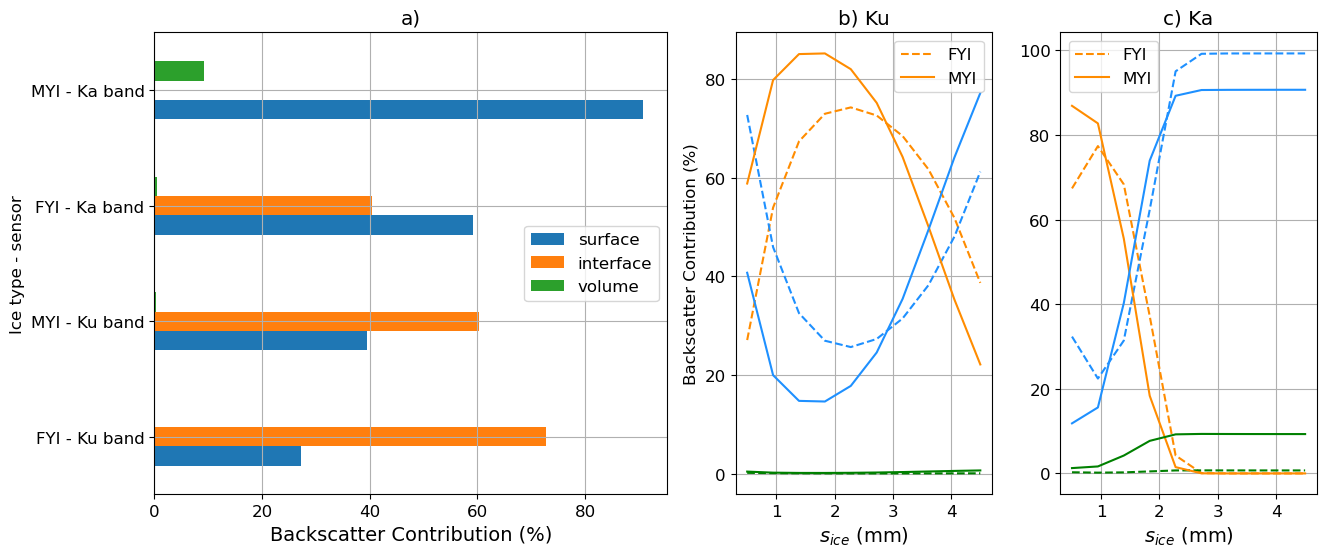

In [30]:
plt.rcParams.update({'font.size': 12})
fig, (ax1, ax2, ax3)  = plt.subplots(nrows=1, ncols=3, figsize=(15,6), gridspec_kw={'width_ratios': [2, 1, 1]})
df.plot(
    x = 'Ice type - sensor',
    kind = 'barh',
    stacked = False,
    title = 'a)',
    ax =ax1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('Backscatter Contribution (%)', size =14)

ax2.plot(rough_array*1000,rough_df_CB_ku.interface,'--', label = 'FYI', color = 'darkorange')
ax2.plot(rough_array*1000,rough_df_CB_ku.surface,'--', color = 'dodgerblue')
ax2.plot(rough_array*1000,rough_df_CB_ku.volume,'--', color = 'green')
ax2.legend()
ax2.plot(rough_array*1000,rough_df_A_ku.interface, label = 'MYI', color = 'darkorange')
ax2.plot(rough_array*1000,rough_df_A_ku.surface, color = 'dodgerblue')
ax2.plot(rough_array*1000,rough_df_A_ku.volume, color = 'green')
ax2.legend()
ax2.set_title('b) Ku')
ax2.set_xlabel('$s_{ice}$ (mm)', size =14)
ax2.set_ylabel('Backscatter Contribution (%)', size =12)
ax2.grid()
#plt.subplots_adjust(wspace= 0.6)
#plt.xlim(-2,105)
ax3.plot(rough_array*1000,rough_df_CB_ka.interface,'--', label = 'FYI', color = 'darkorange')
ax3.plot(rough_array*1000,rough_df_CB_ka.surface,'--', color = 'dodgerblue')
ax3.plot(rough_array*1000,rough_df_CB_ka.volume,'--', color = 'green')
ax3.legend()
ax3.plot(rough_array*1000,rough_df_A_ka.interface, label = 'MYI', color = 'darkorange')
ax3.plot(rough_array*1000,rough_df_A_ka.surface, color = 'dodgerblue')
ax3.plot(rough_array*1000,rough_df_A_ka.volume, color = 'green')
ax3.legend()
ax3.set_title('c) Ka')
ax3.set_xlabel('$s_{ice}$ (mm)', size =14)
#ax3.set_ylabel('Backscatter Contribution (%)', size =12)
ax3.grid()

#plt.savefig('C://Users/julie/OneDrive - USherbrooke/post-doc/AKROSS/article/fig_output/contribution_Ku_ka.png', dpi=300, format='png', bbox_inches='tight')

### 3. sensitivity analysis for Ku

- New simulation are produced, introducing a variation (i.e ± 5 K for temperature) from the measured data (simulation intoduced earlier)
- A lot of functions are introduced to be able to regenerate modified simulation. Some parameters needed different function and tricks to achieve
- Results are plotted against simulation introduced earlier in section 3.1


Lets define the functions that produce modified simulations

In [ ]:
def debye_calc(ssa, density, debye_scaling):
    return debye_scaling * 4 * (1 - density / 917) / (ssa * 917)

def change_snowpack(ratio, list_snowpack, mean_ice_rms, mean_ice_lc, mean_snow_rms, param, salinity, Ka = None):
    """
    get info from original snowpack
    modified the param  (thickness, ssa or salinity) using a ratio from original measurements
    return modified snowpack
    """
    new_snow = list_snowpack
    
    #add roughness and salt for Alert if salinity True
    AK.change_roughness(new_snow, mean_ice_rms, mean_ice_lc, mean_snow_rms, mean_snow_lc, salinity)
    if Ka == True:
        #add roughness for Ka band, need geo optics for snow
        AK.change_roughness_geo(new_snow, mean_ice_rms, mean_ice_lc, mean_snow_rms, mean_snow_lc, salinity)
    for i in range(0, len(new_snow)): 
        snow_layers = new_snow[i].nlayer - 1
        if param == 'thick':
            for n in np.arange(snow_layers):
                new_snow[i].layers[n].thickness = new_snow[i].layers[n].thickness * ratio
        if param == 'ssa':
            for n in np.arange(snow_layers):
                #apply change to ssa therefore corrL
                corrL_change = debye_calc(new_snow[i].layers[n].ssa*ratio , new_snow[i].layers[n].density, 0.7)
                new_snow[i].layers[n].microstructure.corr_length = corrL_change
        if param == 'salinity':
            #apply change to salinity 
            #for n in np.arange(snow_layers):
            new_snow[i].layers[-2].salinity = new_snow[i].layers[-2].salinity * ratio
            
    return new_snow

In [ ]:
# change density in snowpack, needs a special function because denisty cannot be modify once snowpack is made
def change_density_temp(list_snowpack, ratio, type_ice, temp_shift, Ka = None):
    """
    redefine snowpack from scratch because density and temperautre are read only (cannot be modified)
    ratio :  modified density with this ratio
    temp_shift :  add or reduce temperature
    return modified snowpack
    """

    new_snow = []
    for i in range(0, len(list_snowpack)): 
        density = [list_snowpack[i].layers[n].density*ratio for n in range(0, list_snowpack[i].nlayer - 1)]
        depth = [list_snowpack[i].layers[n].thickness for n in range(0, list_snowpack[i].nlayer - 1)]
        temperature = [list_snowpack[i].layers[n].temperature  + temp_shift for n in range(0, list_snowpack[i].nlayer - 1)]
        corr_length = [list_snowpack[i].layers[n].microstructure.corr_length for n in range(0, list_snowpack[i].nlayer - 1)]
        #salinity = [list_snowpack[i].layers[n].salinity for n in range(0, list_snowpack[i].nlayer - 1)]
        
        sea_ice_density = 910
        if 'FYI' == type_ice:
            mean_ice_rms = mean_ice_rms_fyi
            mean_ice_lc = mean_ice_lc_fyi
            ice = make_ice_column(ice_type='firstyear',
                    thickness=[2], temperature=260, 
                    microstructure_model='independent_sphere',
                    radius=1e-3,
                    brine_inclusion_shape='spheres',
                    density=sea_ice_density,
                    salinity=5*PSU,
                    add_water_substrate=True)
            #add salt for Eureka
            salinity = []
            for m in np.arange(list_snowpack[i].nlayer - 2):
                salinity.append(0.5 * PSU)
            salinity.append(eureka_salt * PSU)

        else:
            mean_ice_rms = mean_ice_rms_myi
            mean_ice_lc = mean_ice_lc_myi
            ice = make_ice_column(ice_type='multiyear',
                    thickness=[3], temperature=260, microstructure_model='independent_sphere',
                    radius=1e-3,
                    brine_inclusion_shape='spheres',
                    density=sea_ice_density,
                    salinity=5*PSU,
                    add_water_substrate=True)
            #add salt for Alert
            salinity = []
            for m in np.arange(list_snowpack[i].nlayer - 2):
                salinity.append(0.05 * PSU)
            salinity.append(alert_salt * PSU)
            
        snowpack = make_snowpack(depth, microstructure_model='exponential',
                        ice_permittivity_model=None, density=density , 
                        corr_length=corr_length, temperature = temperature,
                        salinity= salinity) + ice
        
        new_snow.append(snowpack)
    AK.change_roughness(new_snow, mean_ice_rms, mean_ice_lc, mean_snow_rms, mean_snow_lc, False)
    if Ka == True:
        #add roughness for Ka band, need geo optics for snow
        AK.change_roughness_geo(new_snow, mean_ice_rms, mean_ice_lc, mean_snow_rms, mean_snow_lc, False)
    return new_snow

In [ ]:
# change microstructure in snowpack, needs a special function to recompute ssa an get Radios for IND and shs
def change_micro_IND_SHS(list_snowpack, type_ice, micro_model, Ka = None):
    """
    redefine snowpack from scratch to change microstructre model 
    only used for Ka band, useless for Ku... not sensitive to SSA anyway
    return modified snowpack
    """
    new_snow = []
    for i in range(0, len(list_snowpack)): 
        density = [list_snowpack[i].layers[n].density for n in range(0, list_snowpack[i].nlayer - 1)]
        depth = [list_snowpack[i].layers[n].thickness for n in range(0, list_snowpack[i].nlayer - 1)]
        temperature = [list_snowpack[i].layers[n].temperature for n in range(0, list_snowpack[i].nlayer - 1)]
        corr_length = [list_snowpack[i].layers[n].microstructure.corr_length for n in range(0, list_snowpack[i].nlayer - 1)]
        #salinity = [list_snowpack[i].layers[n].salinity for n in range(0, list_snowpack[i].nlayer - 1)]
        
        sea_ice_density = 910
        if 'FYI' == type_ice:
            mean_ice_rms = mean_ice_rms_fyi
            mean_ice_lc = mean_ice_lc_fyi
            ice = make_ice_column(ice_type='firstyear',
                    thickness=[2], temperature=260, 
                    microstructure_model='independent_sphere',
                    radius=1e-3,
                    brine_inclusion_shape='spheres',
                    density=sea_ice_density,
                    salinity=5*PSU,
                    add_water_substrate=True)
            #add salt for Eureka
            salinity = []
            for m in np.arange(list_snowpack[i].nlayer - 2):
                salinity.append(0.1 * PSU)
            salinity.append(eureka_salt * PSU)

        else:
            mean_ice_rms = mean_ice_rms_myi
            mean_ice_lc = mean_ice_lc_myi
            ice = make_ice_column(ice_type='multiyear',
                    thickness=[3], temperature=260, microstructure_model='independent_sphere',
                    radius=1e-3,
                    brine_inclusion_shape='spheres',
                    density=sea_ice_density,
                    salinity=5*PSU,
                    add_water_substrate=True)
            #add salt for Alert
            salinity = []
            for m in np.arange(list_snowpack[i].nlayer - 2):
                salinity.append(0.1 * PSU)
            salinity.append(alert_salt * PSU)
            
        debye_scaling = 0.75   
        #inverse debye equation, get ssa from corr length
        ssa =  debye_scaling * 4 * (1 - np.array(density) / 917) / (np.array(corr_length) * 917) 
        radius = 3/(917*ssa)
        if micro_model == 'ind':
            snowpack = make_snowpack(depth, microstructure_model= 'independent_sphere',
                        ice_permittivity_model=None, density=density , 
                        radius= radius, temperature = temperature,
                        salinity= salinity) + ice
            new_snow.append(snowpack)
            
        if micro_model == 'shs':
            stickiness = 0.1 #Vargel et al 2020
            snowpack = make_snowpack(depth, microstructure_model= 'sticky_hard_spheres',
                        ice_permittivity_model=None, density=density , stickiness = stickiness,
                        radius= radius, temperature = temperature,
                        salinity= salinity) + ice
            new_snow.append(snowpack)
            
    AK.change_roughness(new_snow, mean_ice_rms, mean_ice_lc, mean_snow_rms, mean_snow_lc, False)   
    if Ka == True:
        #add roughness for Ka band, need geo optics for snow
        AK.change_roughness_geo(new_snow, mean_ice_rms, mean_ice_lc, mean_snow_rms, mean_snow_lc, False)
    return new_snow

Create modified snowpack

In [ ]:
#Depth
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_depth_p50 = change_snowpack(1.5, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi, 
                               mean_ice_lc_fyi, mean_snow_rms, 'thick', salinity=eureka_salt)
CB_depth_m50 = change_snowpack(0.5, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi,
                                mean_ice_lc_fyi, mean_snow_rms, 'thick', salinity=eureka_salt)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_depth_p50 = change_snowpack(1.5, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None), 
                                    mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, 'thick', salinity = alert_salt)
A_depth_m50 = change_snowpack(0.5, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None), 
                                    mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, 'thick', salinity = alert_salt)

In [ ]:
#SSA
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_ssa_p20 = change_snowpack(1.2, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi, mean_ice_lc_fyi,
                             mean_snow_rms, 'ssa', salinity=eureka_salt)
CB_ssa_m20 = change_snowpack(0.8, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi, mean_ice_lc_fyi,
                             mean_snow_rms, 'ssa', salinity=eureka_salt)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_ssa_p20 = change_snowpack(1.2, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None), 
                                  mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, 'ssa', salinity= alert_salt)
A_ssa_m20 = change_snowpack(0.8, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None), 
                                  mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, 'ssa', salinity= alert_salt)

In [ ]:
#temperature
CB_temp_p10 = change_density_temp(build_snowpack_FYI(list_smp_CB, eureka_sub_files), 1, 'FYI', 5)
CB_temp_m10 = change_density_temp(build_snowpack_FYI(list_smp_CB, eureka_sub_files), 1, 'FYI', -5)
A_temp_p10 = change_density_temp(AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                  1, 'MYI', 5)
A_temp_m10 = change_density_temp(AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                  1, 'MYI', -5)

In [ ]:
#Density
CB_density_p20 = change_density_temp(build_snowpack_FYI(list_smp_CB, eureka_sub_files), 1.2, 'FYI', 0)
CB_density_m20 = change_density_temp(build_snowpack_FYI(list_smp_CB, eureka_sub_files), 0.8, 'FYI', 0)
A_density_p20 = change_density_temp(AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                     1.2, 'MYI', 0)
A_density_m20 = change_density_temp(AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                     0.8, 'MYI', 0)

In [ ]:
#Salt of snow
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_salt_p50 = change_snowpack(1.5, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi, mean_ice_lc_fyi, 
                               mean_snow_rms, 'salinity', salinity=eureka_salt)
CB_salt_m50 = change_snowpack(0.5, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi, mean_ice_lc_fyi, 
                              mean_snow_rms,'salinity', salinity=eureka_salt)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_salt_p50 = change_snowpack(1.5, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None), 
                                   mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, 'salinity', salinity= alert_salt)
A_salt_m50 = change_snowpack(0.5, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                   mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, 'salinity', salinity= alert_salt)

In [ ]:
#roughness of snow
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_rough_s_p1 = change_snowpack(1, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi, mean_ice_lc_fyi, 
                                mean_snow_rms + 0.005, 'ssa', salinity=eureka_salt)
CB_rough_s_m1 = change_snowpack(1, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi, mean_ice_lc_fyi, 
                                mean_snow_rms - 0.005,'ssa', salinity=eureka_salt)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_rough_s_p1 = change_snowpack(1, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None), 
                                     mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms + 0.005, 'ssa', salinity= alert_salt)
A_rough_s_m1 = change_snowpack(1, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                     mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms - 0.005, 'ssa', salinity= alert_salt)

In [ ]:
#roughness of ice
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_rough_p1 = change_snowpack(1, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi + 0.0005,  mean_ice_lc_fyi - 0.05, 
                              mean_snow_rms, 'ssa', salinity=eureka_salt)
CB_rough_m1 = change_snowpack(1, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi - 0.0005, mean_ice_lc_fyi + 0.05, 
                               mean_snow_rms,'ssa', salinity=eureka_salt)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_rough_p1 = change_snowpack(1, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                   mean_ice_rms_myi + 0.0005,  mean_ice_lc_myi - 0.02, mean_snow_rms, 'ssa', salinity= alert_salt)
A_rough_m1 = change_snowpack(1, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                   mean_ice_rms_myi - 0.0005,  mean_ice_lc_myi+ 0.05, mean_snow_rms, 'ssa', salinity= alert_salt)

In [ ]:
#ice volume fration
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_vf_p1 = build_snowpack_FYI(list_smp_CB, eureka_sub_files, ice_salinity = 5*1.5)
CB_vf_m1 = build_snowpack_FYI(list_smp_CB, eureka_sub_files, ice_salinity = 5*0.5)
AK.change_roughness(CB_vf_p1, mean_ice_rms_fyi, mean_ice_lc_fyi, mean_snow_rms, mean_snow_lc, salinity = eureka_salt)
AK.change_roughness(CB_vf_m1, mean_ice_rms_fyi, mean_ice_lc_fyi, mean_snow_rms, mean_snow_lc, salinity = eureka_salt)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_vf_p1 = AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None, sea_ice_density = 917)
A_vf_m1 = AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None, sea_ice_density = 880*0.95)
AK.change_roughness(A_vf_p1, mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, mean_snow_lc, salinity = alert_salt)
AK.change_roughness(A_vf_m1, mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, mean_snow_lc, salinity = alert_salt)

In [ ]:
#ice temp
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_iceT_p1 = build_snowpack_FYI(list_smp_CB, eureka_sub_files, ice_temp = 265)
CB_iceT_m1 = build_snowpack_FYI(list_smp_CB, eureka_sub_files, ice_temp = 255)
AK.change_roughness(CB_iceT_p1, mean_ice_rms_fyi, mean_ice_lc_fyi, mean_snow_rms, mean_snow_lc, salinity = eureka_salt)
AK.change_roughness(CB_iceT_m1, mean_ice_rms_fyi, mean_ice_lc_fyi, mean_snow_rms, mean_snow_lc, salinity = eureka_salt)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_iceT_p1 = AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, sea_ice_density = 880,
                              permittivity = None, sea_ice_temp = 265)
A_iceT_m1 = AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, sea_ice_density = 880,
                              permittivity = None, sea_ice_temp = 255)
AK.change_roughness(A_iceT_p1, mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, mean_snow_lc, salinity = alert_salt)
AK.change_roughness(A_iceT_m1, mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, mean_snow_lc, salinity = alert_salt)

get modified waveform from modified snowpack

In [ ]:
altimodel = make_model(derived_IBA(ssp), "nadir_lrm_altimetry", rtsolver_options=dict(theta_inc_sampling=8))
cryosat = altimeter_list.cryosat2_sin()
res_CB_Ku_depth_p50 = np.mean(altimodel.run(cryosat, CB_depth_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_depth_m50 = np.mean(altimodel.run(cryosat, CB_depth_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_depth_p50 = np.mean(altimodel.run(cryosat, A_depth_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_depth_m50 = np.mean(altimodel.run(cryosat, A_depth_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ku_ssa_p20 = np.mean(altimodel.run(cryosat, CB_ssa_p20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_ssa_m20 = np.mean(altimodel.run(cryosat, CB_ssa_m20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_ssa_p20 = np.mean(altimodel.run(cryosat, A_ssa_p20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_ssa_m20 = np.mean(altimodel.run(cryosat, A_ssa_m20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ku_temp_p10 = np.mean(altimodel.run(cryosat, CB_temp_p10, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_temp_m10 = np.mean(altimodel.run(cryosat, CB_temp_m10, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_temp_p10 = np.mean(altimodel.run(cryosat, A_temp_p10, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_temp_m10 = np.mean(altimodel.run(cryosat, A_temp_m10, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ku_density_p20 = np.mean(altimodel.run(cryosat, CB_density_p20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_density_m20 = np.mean(altimodel.run(cryosat, CB_density_m20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_density_p20 = np.mean(altimodel.run(cryosat, A_density_p20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_density_m20 = np.mean(altimodel.run(cryosat, A_density_m20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ku_salt_p50 = np.mean(altimodel.run(cryosat, CB_salt_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_salt_m50 = np.mean(altimodel.run(cryosat, CB_salt_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_salt_p50 = np.mean(altimodel.run(cryosat, A_salt_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_salt_m50 = np.mean(altimodel.run(cryosat, A_salt_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ku_rough_p1 = np.mean(altimodel.run(cryosat, CB_rough_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_rough_m1 = np.mean(altimodel.run(cryosat, CB_rough_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_rough_p1 = np.mean(altimodel.run(cryosat, A_rough_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_rough_m1 = np.mean(altimodel.run(cryosat, A_rough_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ku_rough_s_p1 = np.mean(altimodel.run(cryosat, CB_rough_s_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_rough_s_m1 = np.mean(altimodel.run(cryosat, CB_rough_s_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_rough_s_p1 = np.mean(altimodel.run(cryosat, A_rough_s_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_rough_s_m1 = np.mean(altimodel.run(cryosat, A_rough_s_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ku_vf_p1 = np.mean(altimodel.run(cryosat, CB_vf_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_vf_m1 = np.mean(altimodel.run(cryosat, CB_vf_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_vf_p1 = np.mean(altimodel.run(cryosat, A_vf_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_vf_m1 = np.mean(altimodel.run(cryosat, A_vf_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ku_iceT_p1 = np.mean(altimodel.run(cryosat, CB_iceT_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_iceT_m1 = np.mean(altimodel.run(cryosat, CB_iceT_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_iceT_p1 = np.mean(altimodel.run(cryosat, A_iceT_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_iceT_m1 = np.mean(altimodel.run(cryosat, A_iceT_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

plot results

In [ ]:
#generate x fro number of bins
x = range(0,len(res_CB_Ku_depth_p50))

# Plot results
plt.close()
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(12,12),
                                                                         sharey =True, sharex = True)
plt.rcParams.update({'font.size': 12})
ax1.set_title('a) Snow depth ± 50%', size = 13)
ax1.plot(res_CB_Ku_depth_p50, linestyle = '--',color = 'darkorange')
ax1.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI')
ax1.plot(res_CB_Ku_depth_m50, linestyle = ':',color = 'darkorange')
ax1.fill_between(x, y1 = res_CB_Ku_depth_p50, y2 = res_CB_Ku_depth_m50, alpha =0.1, color = 'darkorange')

ax1.plot(res_A_Ku_depth_p50, linestyle = '--',color = 'dodgerblue')
ax1.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI')
ax1.plot(res_A_Ku_depth_m50, linestyle = ':',color = 'dodgerblue')
ax1.fill_between(x, y1 = res_A_Ku_depth_p50, y2 = res_A_Ku_depth_m50, alpha =0.1, color = 'dodgerblue')
ax1.legend()
ax1.set_xlim(155,190)
ax1.set_ylabel('Power normalized')
ax1.set_yscale('log')
ax1.grid()


ax2.set_title('b) SSA ± 20%', size = 13)
ax2.plot(res_CB_Ku_ssa_p20, linestyle = '--',color = 'darkorange')
ax2.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14,color = 'darkorange', label = 'FYI ± 50%')
ax2.plot(res_CB_Ku_ssa_m20, linestyle = ':',color = 'darkorange')

ax2.plot(res_A_Ku_ssa_p20, linestyle = '--',color = 'dodgerblue')
ax2.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14,color = 'dodgerblue', label = 'MYI ± 50%')
ax2.plot(res_A_Ku_ssa_m20, linestyle = ':',color = 'dodgerblue')
#ax2.legend()
ax2.grid()
ax2.set_xlim(155,190)


ax3.set_title('c) Snow temperature (260 K) ± 5K', size = 13)
ax3.plot(res_CB_Ku_temp_p10, linestyle = '--',color = 'darkorange')
ax3.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14, color = 'darkorange')
ax3.plot(res_CB_Ku_temp_m10, linestyle = ':',color = 'darkorange')
ax3.fill_between(x, y1 = res_CB_Ku_temp_p10, y2 = res_CB_Ku_temp_m10, alpha =0.1, color = 'darkorange')

ax3.plot(res_A_Ku_temp_p10, linestyle = '--',color = 'dodgerblue')
ax3.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14, color = 'dodgerblue')
ax3.plot(res_A_Ku_temp_m10, linestyle = ':',color = 'dodgerblue')
ax3.fill_between(x, y1 = res_A_Ku_temp_p10, y2 = res_A_Ku_temp_m10, alpha =0.1, color = 'dodgerblue')
ax3.grid()
ax3.set_xlim(155,190)
ax3.set_ylabel('Power normalized')


ax4.set_title('d) Snow density ± 20%', size = 13)
ax4.plot(res_CB_Ku_density_p20, linestyle = '--',color = 'darkorange')
ax4.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax4.plot(res_CB_Ku_density_m20, linestyle = ':',color = 'darkorange')
ax4.fill_between(x, y1 = res_CB_Ku_density_p20, y2 = res_CB_Ku_density_m20, alpha =0.1, color = 'darkorange')
ax4.plot(res_A_Ku_density_p20, linestyle = '--',color = 'dodgerblue')
ax4.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax4.plot(res_A_Ku_density_m20, linestyle = ':',color = 'dodgerblue')
ax4.fill_between(x, y1 = res_A_Ku_density_p20, y2 = res_A_Ku_density_m20, alpha =0.1, color = 'dodgerblue')
#ax3.legend()
ax4.grid()
ax4.set_xlim(155,190)


ax5.set_title('e) Snow salinity ± 50%', size = 13)
ax5.plot(res_CB_Ku_salt_p50, linestyle = '--',color = 'darkorange')
ax5.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax5.plot(res_CB_Ku_salt_m50, linestyle = ':',color = 'darkorange')
ax5.fill_between(x, y1 = res_CB_Ku_salt_p50, y2 = res_CB_Ku_salt_m50, alpha =0.1, color = 'darkorange')
ax5.plot(res_A_Ku_salt_p50, linestyle = '--',color = 'dodgerblue')
ax5.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax5.plot(res_A_Ku_salt_m50, linestyle = ':',color = 'dodgerblue')
ax5.fill_between(x, y1 = res_A_Ku_salt_p50, y2 = res_A_Ku_salt_m50, alpha =0.1, color = 'dodgerblue')
#ax3.legend()
ax5.grid()
ax5.set_xlim(155,190)

ax6.set_title('f) Snow : $s_{surf}$ ± 0.5 mm', size =13)
ax6.plot(res_CB_Ku_rough_s_p1, linestyle = '--',color = 'darkorange')
ax6.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax6.plot(res_CB_Ku_rough_s_m1, linestyle = ':',color = 'darkorange')
ax6.fill_between(x, y1 = res_CB_Ku_rough_s_p1, y2 = res_CB_Ku_rough_s_m1, alpha =0.1, color = 'darkorange')
ax6.plot(res_A_Ku_rough_s_p1, linestyle = '--',color = 'dodgerblue')
ax6.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax6.plot(res_A_Ku_rough_s_m1, linestyle = ':',color = 'dodgerblue')
ax6.fill_between(x, y1 = res_A_Ku_rough_s_p1, y2 = res_A_Ku_rough_s_m1, alpha =0.1, color = 'dodgerblue')
#ax5.legend()
ax6.set_xlim(155,190)
ax6.grid()

ax7.set_title('g) Sea ice : $s_{surf}$ ± 0.5 mm \n Sea ice : $l_c$ $\mp$ 5 cm', size =13)
ax7.plot(res_CB_Ku_rough_p1, linestyle = '--',color = 'darkorange')
ax7.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax7.plot(res_CB_Ku_rough_m1, linestyle = ':',color = 'darkorange')
ax7.fill_between(x, y1 = res_CB_Ku_rough_p1, y2 = res_CB_Ku_rough_m1, alpha =0.1, color = 'darkorange')
ax7.plot(res_A_Ku_rough_p1, linestyle = '--',color = 'dodgerblue')
ax7.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax7.plot(res_A_Ku_rough_m1, linestyle = ':',color = 'dodgerblue')
ax7.fill_between(x, y1 = res_A_Ku_rough_p1, y2 = res_A_Ku_rough_m1, alpha =0.1, color = 'dodgerblue')
#ax4.legend()
ax7.set_xlim(155,190)
ax7.set_ylabel('Power normalized')
ax7.set_xlabel('Gate')
ax7.grid()

ax8.set_title('h) Sea ice : FYI salinity ±  50 % \n Sea ice : MYI density ±  5% ', size = 13)
ax8.plot(res_CB_Ku_vf_p1, linestyle = '--',color = 'darkorange')
ax8.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax8.plot(res_CB_Ku_vf_m1, linestyle = ':',color = 'darkorange')
ax8.fill_between(x, y1 = res_CB_Ku_vf_p1, y2 = res_CB_Ku_vf_m1, alpha =0.1, color = 'darkorange')
ax8.plot(res_A_Ku_vf_p1, linestyle = '--',color = 'dodgerblue')
ax8.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax8.plot(res_A_Ku_vf_m1, linestyle = ':',color = 'dodgerblue')
ax8.fill_between(x, y1 = res_A_Ku_vf_p1, y2 = res_A_Ku_vf_m1, alpha =0.1, color = 'dodgerblue')
#ax4.legend()
ax8.set_xlim(155,190)
ax8.set_xlabel('Gate')
ax8.grid()

ax9.set_title('i) Sea ice temperature : 260 ± 5 K', size =13)
ax9.plot(res_CB_Ku_iceT_p1, linestyle = '--',color = 'darkorange')
ax9.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax9.plot(res_CB_Ku_iceT_m1, linestyle = ':',color = 'darkorange')
ax9.fill_between(x, y1 = res_CB_Ku_iceT_p1, y2 = res_CB_Ku_iceT_m1, alpha =0.1, color = 'darkorange')
ax9.plot(res_A_Ku_iceT_p1, linestyle = '--',color = 'dodgerblue')
ax9.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax9.plot(res_A_Ku_iceT_m1, linestyle = ':',color = 'dodgerblue')
ax9.fill_between(x, y1 = res_A_Ku_iceT_p1, y2 = res_A_Ku_iceT_m1, alpha =0.1, color = 'dodgerblue')
#ax4.legend()
ax9.set_xlim(120,320)
ax9.set_xlabel('Gate')
ax9.grid()

ax1.set_ylim(10e-3, 10)

# plt.savefig('C://Users/julie/OneDrive - USherbrooke/post-doc/AKROSS/article/fig_output/sensitivity_analysis.png', 
#             dpi=300, format='png', bbox_inches='tight')

### 4. Sentivity for Ka
 same as 3 but for Ka

In [ ]:
#Depth
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_depth_Ka_p50 = change_snowpack(1.5, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi, mean_ice_lc_fyi, 
                                  mean_snow_rms, 'thick', salinity=eureka_salt, Ka = True)
CB_depth_Ka_m50 = change_snowpack(0.5, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi, mean_ice_lc_fyi,
                                  mean_snow_rms, 'thick', salinity=eureka_salt, Ka = True)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_depth_Ka_p50 = change_snowpack(1.5, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None), 
                                    mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, 'thick', salinity = alert_salt, Ka = True)
A_depth_Ka_m50 = change_snowpack(0.5, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None), 
                                    mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, 'thick', salinity = alert_salt, Ka = True)

In [ ]:
#SSA
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_ssa_Ka_p20 = change_snowpack(1.2, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi, mean_ice_lc_fyi, 
                                mean_snow_rms, 'ssa', salinity=eureka_salt, Ka = True)
CB_ssa_Ka_m20 = change_snowpack(0.8, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi, mean_ice_lc_fyi,
                                mean_snow_rms, 'ssa', salinity=eureka_salt, Ka = True)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_ssa_Ka_p20 = change_snowpack(1.2, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None), 
                                  mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, 'ssa', salinity= alert_salt, Ka = True)
A_ssa_Ka_m20 = change_snowpack(0.8, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None), 
                                  mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, 'ssa', salinity= alert_salt, Ka = True)

In [ ]:
#Different Micro model
CB_ind_Ka = change_micro_IND_SHS(build_snowpack_FYI(list_smp_CB, eureka_sub_files), 'FYI', 'ind', Ka = True)
CB_shs_Ka = change_micro_IND_SHS(build_snowpack_FYI(list_smp_CB, eureka_sub_files), 'FYI', 'shs', Ka = True)
A_ind_Ka = change_micro_IND_SHS(AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                 'MYI', 'ind', Ka = True)
A_shs_Ka = change_micro_IND_SHS(AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                 'MYI', 'shs', Ka = True)

In [ ]:
#temperature
CB_temp_Ka_p10 = change_density_temp(build_snowpack_FYI(list_smp_CB, eureka_sub_files), 1, 'FYI', 5, Ka = True)
CB_temp_Ka_m10 = change_density_temp(build_snowpack_FYI(list_smp_CB, eureka_sub_files), 1, 'FYI', -5, Ka = True)
A_temp_Ka_p10 = change_density_temp(AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                     1, 'MYI', 5, Ka = True)
A_temp_Ka_m10 = change_density_temp(AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                     1, 'MYI', -5, Ka = True)

In [ ]:
#Density
CB_density_Ka_p20 = change_density_temp(build_snowpack_FYI(list_smp_CB, eureka_sub_files), 1.2, 'FYI', 0, Ka = True)
CB_density_Ka_m20 = change_density_temp(build_snowpack_FYI(list_smp_CB, eureka_sub_files), 0.8, 'FYI', 0, Ka = True)
A_density_Ka_p20 = change_density_temp(AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                        1.2, 'MYI', 0, Ka = True)
A_density_Ka_m20 = change_density_temp(AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                        0.8, 'MYI', 0, Ka = True)

In [ ]:
#roughness of ice
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_rough_Ka_p1 = change_snowpack(1, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi + 0.0005, mean_ice_lc_fyi - 0.05,
                                  mean_snow_rms, 'ssa', salinity=eureka_salt, Ka = True)
CB_rough_Ka_m1 = change_snowpack(1, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi - 0.0005, mean_ice_lc_fyi + 0.05,
                                  mean_snow_rms,'ssa', salinity=eureka_salt, Ka = True)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_rough_Ka_p1 = change_snowpack(1, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                   mean_ice_rms_myi + 0.0005, mean_ice_lc_myi - 0.05, mean_snow_rms, 'ssa', salinity= alert_salt, Ka = True)
A_rough_Ka_m1 = change_snowpack(1, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                   mean_ice_rms_myi - 0.0005, mean_ice_lc_myi + 0.05, mean_snow_rms, 'ssa', salinity= alert_salt, Ka = True)

In [ ]:
#roughness of snow
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_rough_s_Ka_p1 = change_snowpack(1, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi, mean_ice_lc_fyi, 
                                    mean_snow_rms + 0.002, 'ssa', salinity=eureka_salt, Ka = True)
CB_rough_s_Ka_m1 = change_snowpack(1, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi, mean_ice_lc_fyi,
                                    mean_snow_rms - 0.002,'ssa', salinity=eureka_salt, Ka = True)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_rough_s_Ka_p1 = change_snowpack(1, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None), 
                                     mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms + 0.002, 'ssa', salinity= alert_salt, Ka = True)
A_rough_s_Ka_m1 = change_snowpack(1, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None),
                                     mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms - 0.002, 'ssa', salinity= alert_salt, Ka = True)

In [ ]:
#Salt of snow
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_salt_Ka_p50 = change_snowpack(1.5, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi, mean_ice_lc_fyi, mean_snow_rms,
                                  'salinity', salinity=eureka_salt, Ka = True)
CB_salt_Ka_m50 = change_snowpack(0.5, build_snowpack_FYI(list_smp_CB, eureka_sub_files), mean_ice_rms_fyi, mean_ice_lc_fyi, mean_snow_rms,
                                 'salinity', salinity=eureka_salt, Ka = True)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_salt_Ka_p50 = change_snowpack(1.5, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, 
                                                      permittivity = None), mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms,
                                                        'salinity', salinity= alert_salt, Ka = True)
A_salt_Ka_m50 = change_snowpack(0.5, AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False,
                                                       permittivity = None) ,mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, 
                                                       'salinity', salinity= alert_salt, Ka = True)

In [ ]:
#ice volume fration
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_vf_Ka_p1 = build_snowpack_FYI(list_smp_CB, eureka_sub_files, ice_salinity = 5*1.5)
CB_vf_Ka_m1 = build_snowpack_FYI(list_smp_CB, eureka_sub_files, ice_salinity = 5*0.5)
AK.change_roughness_geo(CB_vf_Ka_p1, mean_ice_rms_fyi, mean_ice_lc_fyi, mean_snow_rms, mean_snow_lc, salinity = eureka_salt)
AK.change_roughness_geo(CB_vf_Ka_m1, mean_ice_rms_fyi, mean_ice_lc_fyi, mean_snow_rms, mean_snow_lc, salinity = eureka_salt)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_vf_Ka_p1 = AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None, 
                              sea_ice_density = 917)
A_vf_Ka_m1 = AK.smp_snowpacks(alert_smp_files, layer_thickness=0.03, rough=False, permittivity = None, 
                              sea_ice_density = 880*0.95)
AK.change_roughness_geo(A_vf_Ka_p1, mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, mean_snow_lc, salinity = alert_salt)
AK.change_roughness_geo(A_vf_Ka_m1, mean_ice_rms_myi, mean_ice_lc_myi, mean_snow_rms, mean_snow_lc, salinity = alert_salt)

In [ ]:
altimodel = make_model(derived_IBA(ssp), "nadir_lrm_altimetry", rtsolver_options=dict(theta_inc_sampling=8))
#cryosat = altimeter_list.cryosat2_sin()
altika = altimeter_list.saral_altika()
res_CB_Ka_depth_p50 = np.mean(altimodel.run(altika, CB_depth_Ka_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_CB_Ka_depth_m50 = np.mean(altimodel.run(altika, CB_depth_Ka_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_depth_p50 = np.mean(altimodel.run(altika, A_depth_Ka_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_depth_m50 = np.mean(altimodel.run(altika, A_depth_Ka_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-16

res_CB_Ka_ssa_p20 = np.mean(altimodel.run(altika, CB_ssa_Ka_p20, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_CB_Ka_ssa_m20 = np.mean(altimodel.run(altika, CB_ssa_Ka_m20, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_ssa_p20 = np.mean(altimodel.run(altika, A_ssa_Ka_p20, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_ssa_m20 = np.mean(altimodel.run(altika, A_ssa_Ka_m20, parallel_computation=True).sigma(), axis = 0)/normf/1e-16

res_CB_Ka_ind = np.mean(altimodel.run(altika, CB_ind_Ka, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_CB_Ka_shs = np.mean(altimodel.run(altika, CB_shs_Ka, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_ind = np.mean(altimodel.run(altika, A_ind_Ka, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_shs = np.mean(altimodel.run(altika, A_shs_Ka, parallel_computation=True).sigma(), axis = 0)/normf/1e-16

res_CB_Ka_temp_p10 = np.mean(altimodel.run(altika, CB_temp_Ka_p10, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_CB_Ka_temp_m10 = np.mean(altimodel.run(altika, CB_temp_Ka_m10, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_temp_p10 = np.mean(altimodel.run(altika, A_temp_Ka_p10, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_temp_m10 = np.mean(altimodel.run(altika, A_temp_Ka_m10, parallel_computation=True).sigma(), axis = 0)/normf/1e-16

res_CB_Ka_density_p20 = np.mean(altimodel.run(altika, CB_density_Ka_p20, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_CB_Ka_density_m20 = np.mean(altimodel.run(altika, CB_density_Ka_m20, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_density_p20 = np.mean(altimodel.run(altika, A_density_Ka_p20, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_density_m20 = np.mean(altimodel.run(altika, A_density_Ka_m20, parallel_computation=True).sigma(), axis = 0)/normf/1e-16

res_CB_Ka_salt_p50 = np.mean(altimodel.run(altika, CB_salt_Ka_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_CB_Ka_salt_m50 = np.mean(altimodel.run(altika, CB_salt_Ka_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_salt_p50 = np.mean(altimodel.run(altika, A_salt_Ka_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_salt_m50 = np.mean(altimodel.run(altika, A_salt_Ka_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-16

res_CB_Ka_rough_p1 = np.mean(altimodel.run(altika, CB_rough_Ka_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_CB_Ka_rough_m1 = np.mean(altimodel.run(altika, CB_rough_Ka_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_rough_p1 = np.mean(altimodel.run(altika, A_rough_Ka_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_rough_m1 = np.mean(altimodel.run(altika, A_rough_Ka_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-16

res_CB_Ka_rough_s_p1 = np.mean(altimodel.run(altika, CB_rough_s_Ka_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_CB_Ka_rough_s_m1 = np.mean(altimodel.run(altika, CB_rough_s_Ka_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_rough_s_p1 = np.mean(altimodel.run(altika, A_rough_s_Ka_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_rough_s_m1 = np.mean(altimodel.run(altika, A_rough_s_Ka_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-16

res_CB_Ka_vf_p1 = np.mean(altimodel.run(altika, CB_vf_Ka_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_CB_Ka_vf_m1 = np.mean(altimodel.run(altika, CB_vf_Ka_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_vf_p1 = np.mean(altimodel.run(altika, A_vf_Ka_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-16
res_A_Ka_vf_m1 = np.mean(altimodel.run(altika, A_vf_Ka_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-16

In [ ]:
#generate x fro number of bins
x = range(0,len(res_CB_Ka_depth_p50))

# Plot results
plt.close()
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(12,12), sharex = True, sharey = True)
plt.rcParams.update({'font.size': 12})
ax1.set_title('a) Snow depth ± 50%', size = 13)
ax1.plot(res_CB_Ka_depth_p50, linestyle = '--',color = 'darkorange')
ax1.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-16, color = 'darkorange', label = 'FYI')
ax1.plot(res_CB_Ka_depth_m50, linestyle = ':',color = 'darkorange')
ax1.fill_between(x, y1 = res_CB_Ka_depth_p50, y2 = res_CB_Ka_depth_m50, alpha =0.1, color = 'darkorange')

ax1.plot(res_A_Ka_depth_p50, linestyle = '--',color = 'dodgerblue')
ax1.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-16, color = 'dodgerblue', label = 'MYI')
ax1.plot(res_A_Ka_depth_m50, linestyle = ':',color = 'dodgerblue')
ax1.fill_between(x, y1 = res_A_Ka_depth_p50, y2 = res_A_Ka_depth_m50, alpha =0.1, color = 'dodgerblue')
ax1.legend()
#ax1.set_xlim(155,190)
ax1.set_ylabel('Power normalized (FYI)')
ax1.grid()


ax2.set_title('b) SSA ± 20%', size = 13)
ax2.plot(res_CB_Ka_ssa_p20, linestyle = '--',color = 'darkorange')
ax2.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-16,color = 'darkorange', label = 'FYI')
ax2.plot(res_CB_Ka_ssa_m20, linestyle = ':',color = 'darkorange')

ax2.plot(res_A_Ka_ssa_p20, linestyle = '--',color = 'dodgerblue')
ax2.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-16,color = 'dodgerblue', label = 'MYI')
ax2.plot(res_A_Ka_ssa_m20, linestyle = ':',color = 'dodgerblue')
ax2.fill_between(x, y1 = res_A_Ka_ssa_p20, y2 = res_A_Ka_ssa_m20, alpha =0.1, color = 'dodgerblue')
ax2.legend()
ax2.grid()
#ax2.set_xlim(155,190)

ax3.set_title('c) Microstructure', size = 13)
ax3.plot(res_CB_Ka_ind, linestyle = '--',color = 'darkorange', label = 'IND')
ax3.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-16,color = 'darkorange', label = 'EXP')
ax3.plot(res_CB_Ka_shs, linestyle = ':',color = 'darkorange', label = 'SHS')

ax3.plot(res_A_Ka_ind, linestyle = '--',color = 'dodgerblue')
ax3.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-16,color = 'dodgerblue')
ax3.plot(res_A_Ka_shs, linestyle = ':',color = 'dodgerblue')
ax3.legend()
ax3.set_ylabel('Power Normalized (MYI)')
ax3.grid()
#ax3.set_xlim(155,190)


ax4.set_title('d) Snow temperature (260 K) ± 5K', size = 13)
ax4.plot(res_CB_Ka_temp_p10, linestyle = '--',color = 'darkorange')
ax4.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-16, color = 'darkorange')
ax4.plot(res_CB_Ka_temp_m10, linestyle = ':',color = 'darkorange')
ax4.fill_between(x, y1 = res_CB_Ka_temp_p10, y2 = res_CB_Ka_temp_m10, alpha =0.1, color = 'darkorange')

ax4.plot(res_A_Ka_temp_p10, linestyle = '--',color = 'dodgerblue')
ax4.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-16, color = 'dodgerblue')
ax4.plot(res_A_Ka_temp_m10, linestyle = ':',color = 'dodgerblue')
ax4.fill_between(x, y1 = res_A_Ka_temp_p10, y2 = res_A_Ka_temp_m10, alpha =0.1, color = 'dodgerblue')
ax4.grid()
#ax4.set_xlim(155,190)
ax4.set_ylabel('Power normalized (FYI)')


ax5.set_title('e) Snow density ± 20%', size = 13)
ax5.plot(res_CB_Ka_density_p20, linestyle = '--',color = 'darkorange')
ax5.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-16, color = 'darkorange', label = 'FYI ± 50%')
ax5.plot(res_CB_Ka_density_m20, linestyle = ':',color = 'darkorange')
ax5.fill_between(x, y1 = res_CB_Ka_density_p20, y2 = res_CB_Ka_density_m20, alpha =0.1, color = 'darkorange')

ax5.plot(res_A_Ka_density_p20, linestyle = '--',color = 'dodgerblue')
ax5.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-16, color = 'dodgerblue', label = 'MYI ± 50%')
ax5.plot(res_A_Ka_density_m20, linestyle = ':',color = 'dodgerblue')
ax5.fill_between(x, y1 = res_A_Ka_density_p20, y2 = res_A_Ka_density_m20, alpha =0.1, color = 'dodgerblue')
#ax3.legend()
ax5.grid()
#ax5.set_xlim(155,190)


ax6.set_title('f) Snow salinity ± 50%', size = 13)
ax6.plot(res_CB_Ka_salt_p50, linestyle = '--',color = 'darkorange')
ax6.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-16, color = 'darkorange', label = 'FYI ± 50%')
ax6.plot(res_CB_Ka_salt_m50, linestyle = ':',color = 'darkorange')
ax6.fill_between(x, y1 = res_CB_Ka_salt_p50, y2 = res_CB_Ka_salt_m50, alpha =0.1, color = 'darkorange')

ax6.plot(res_A_Ka_salt_p50, linestyle = '--',color = 'dodgerblue')
ax6.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-16, color = 'dodgerblue', label = 'MYI ± 50%')
ax6.plot(res_A_Ka_salt_m50, linestyle = ':',color = 'dodgerblue')
ax6.fill_between(x, y1 = res_A_Ka_salt_p50, y2 = res_A_Ka_salt_m50, alpha =0.1, color = 'dodgerblue')
#ax3.legend()
ax6.set_ylabel('Power Normalized (MYI)')
ax6.grid()
#ax6.set_xlim(155,190)

ax7.set_title('g) Snow : $s_{snow}$ ± 0.5 mm', size =13)
ax7.plot(res_CB_Ka_rough_s_p1, linestyle = '--',color = 'darkorange')
ax7.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-16, color = 'darkorange', label = 'FYI ± 50%')
ax7.plot(res_CB_Ka_rough_s_m1, linestyle = ':',color = 'darkorange')
ax7.fill_between(x, y1 = res_CB_Ka_rough_s_p1, y2 = res_CB_Ka_rough_s_m1, alpha =0.1, color = 'darkorange')

ax7.plot(res_A_Ka_rough_s_p1, linestyle = '--',color = 'dodgerblue')
ax7.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-16, color = 'dodgerblue', label = 'MYI ± 50%')
ax7.plot(res_A_Ka_rough_s_m1, linestyle = ':',color = 'dodgerblue')
ax7.fill_between(x, y1 = res_A_Ka_rough_s_p1, y2 = res_A_Ka_rough_s_m1, alpha =0.1, color = 'dodgerblue')
#ax5.legend()
ax7.set_xlabel('Gate')
ax7.set_ylabel('Power normalized (FYI)')
ax7.grid()


ax8.set_title('h) Sea ice : $s_{ice}$ ± 0.5 mm \n Sea ice : $l_c$ $\mp$ 5 cm', size =13)
ax8.plot(res_CB_Ka_rough_p1, linestyle = '--',color = 'darkorange')
ax8.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-16, color = 'darkorange', label = 'FYI ± 50%')
ax8.plot(res_CB_Ka_rough_m1, linestyle = ':',color = 'darkorange')
ax8.fill_between(x, y1 = res_CB_Ka_rough_p1, y2 = res_CB_Ka_rough_m1, alpha =0.1, color = 'darkorange')

ax8.plot(res_A_Ka_rough_p1, linestyle = '--',color = 'dodgerblue')
ax8.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-16, color = 'dodgerblue', label = 'MYI ± 50%')
ax8.plot(res_A_Ka_rough_m1, linestyle = ':',color = 'dodgerblue')
ax8.fill_between(x, y1 = res_A_Ka_rough_p1, y2 = res_A_Ka_rough_m1, alpha =0.1, color = 'dodgerblue')
#ax4.legend()
#ax7.set_xlim(155,190)
ax8.set_xlabel('Gate')
ax8.grid()
#ax7.set_ylim(0,0.5)

ax9.set_title('i)  Sea ice : FYI salinity ±  50 % \n Sea ice : MYI density ±  5% ', size =13)
ax9.plot(res_CB_Ka_vf_p1, linestyle = '--',color = 'darkorange')
ax9.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-16, color = 'darkorange', label = 'FYI ± 50%')
ax9.plot(res_CB_Ka_vf_m1, linestyle = ':',color = 'darkorange')
ax9.fill_between(x, y1 = res_CB_Ka_vf_p1, y2 = res_CB_Ka_vf_m1, alpha =0.1, color = 'darkorange')

ax9.plot(res_A_Ka_vf_p1, linestyle = '--',color = 'dodgerblue')
ax9.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-16, color = 'dodgerblue', label = 'MYI ± 50%')
ax9.plot(res_A_Ka_vf_m1, linestyle = ':',color = 'dodgerblue')
ax9.fill_between(x, y1 = res_A_Ka_vf_p1, y2 = res_A_Ka_rough_m1, alpha =0.1, color = 'dodgerblue')
#ax4.legend()
#ax7.set_xlim(155,190)
ax9.set_xlabel('Gate')
ax9.set_ylabel('Power normalized (MYI)')
ax9.grid()
#ax7.set_ylim(0,0.5)

ax1.set_yscale('log')
ax1.set_ylim(10e-2, 10e1)
ax1.set_xlim(40,90)


# plt.savefig('C://Users/julie/OneDrive - USherbrooke/post-doc/AKROSS/article/fig_output/sensitivity_analysis_Ka.png',
#              dpi=300, format='png', bbox_inches='tight')